In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import json
import time
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
import scipy.stats as sps
pyhf.set_backend('jax')

from jax import grad, jit, vmap, value_and_grad, random
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import external3
import external4
import external2
from contextlib import contextmanager

## Model

In [2]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 3],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 55],
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.4],},
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 65, 66], 'lo_data': [40, 40, 40]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [66, 65, 60], 'lo_data': [40, 40, 39]}},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 6.7]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7.27, 9, 7]},
        
         ]},    
                                 
    ]},
    ],
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }
        ],}
)

nBins = len(model.expected_actualdata(model.config.suggested_init()))

### Observations
obs = model.expected_actualdata(model.config.suggested_init())

In [16]:
# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()
obs = workspace.data(model, include_auxdata=False)
nBins = len(model.expected_actualdata(model.config.suggested_init()))

## external3

In [155]:
prepared_priors = external3.prepare_model(model, [[1],[0.01]])
print(prepared_priors)

[array([ 72,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131]), [[1]], [[0.01]], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [156]:
post_data, post_pred = external3.BayesianInference.posterior_sampling(model, obs, prepared_priors, 500)
prior_pred = external3.BayesianInference.prior_sampling(model, obs, prepared_priors, 500)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ttbarXsec]
>Metropolis: [Normals]
CompoundStep
>Metropolis: [ttbarXsec]
>Metropolis: [Normals]


Sampling: [Normals, main, ttbarXsec]


<class 'numpy.ndarray'>
132


## external4

In [17]:
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[1], [0.1]]}
}

prior_dict = external4.prepare_priors(model, unconstr_dict)

prior_dict

{'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[1], [0.1]]},
 'JET_JER_DataVsMC': {'type': 'normal',
  'input': [[0.0], [Array(1., dtype=float64)]]},
 'JET_JER_NP1': {'type': 'normal',
  'input': [[0.0], [Array(1., dtype=float64)]]},
 'JET_JER_NP2': {'type': 'normal',
  'input': [[0.0], [Array(1., dtype=float64)]]},
 'JET_JER_NP3': {'type': 'normal',
  'input': [[0.0], [Array(1., dtype=float64)]]},
 'JET_JER_NP4': {'type': 'normal',
  'input': [[0.0], [Array(1., dtype=float64)]]},
 'JET_JER_NP7': {'type': 'normal',
  'input': [[0.0], [Array(1., dtype=float64)]]},
 'weight_bTagSF_MV2c10_Continuous_eigenvars_C_0': {'type': 'normal',
  'input': [[0.0], [Array(1., dtype=float64)]]},
 'weight_bTagSF_MV2c10_Continuous_eigenvars_C_1': {'type': 'normal',
  'input': [[0.0], [Array(1., dtype=float64)]]},
 'weight_bTagSF_MV2c10_Continuous_eigenvars_Light_0': {'type': 'normal',
  'input': [[0.0], [Array(1., dtype=float64)]]},
 'weight_bTagSF_MV2c10_Continuous_eigenvars_Light_1':

In [18]:
prepared_model = external4.prepare_model(model=model, observations=obs, precision=0.2, priors=prior_dict)

prepared_model

{'model': <pyhf.pdf.Model at 0x150724a60>,
 'obs': [1098791.0,
  659004.0,
  568147.0,
  482465.0,
  406459.0,
  338510.0,
  280579.0,
  227926.0,
  179014.0,
  132448.0,
  90176.0,
  77367.0,
  55607.0,
  91196.0,
  117193.0,
  132356.0,
  139301.0,
  131759.0,
  116803.0,
  97272.0,
  77137.0,
  56667.0,
  38697.0,
  22873.0,
  23697.0,
  40736.0,
  84320.0,
  123233.0,
  145030.0,
  147906.0,
  133982.0,
  112709.0,
  95499.0,
  74305.0,
  54185.0,
  38037.0,
  53375.0],
 'priors': {'uncon1': {'type': 'unconstrained',
   'type2': 'normal',
   'input': [[1], [0.1]]},
  'JET_JER_DataVsMC': {'type': 'normal',
   'input': [[0.0], [Array(1., dtype=float64)]]},
  'JET_JER_NP1': {'type': 'normal',
   'input': [[0.0], [Array(1., dtype=float64)]]},
  'JET_JER_NP2': {'type': 'normal',
   'input': [[0.0], [Array(1., dtype=float64)]]},
  'JET_JER_NP3': {'type': 'normal',
   'input': [[0.0], [Array(1., dtype=float64)]]},
  'JET_JER_NP4': {'type': 'normal',
   'input': [[0.0], [Array(1., dtype=fl

## Plotting

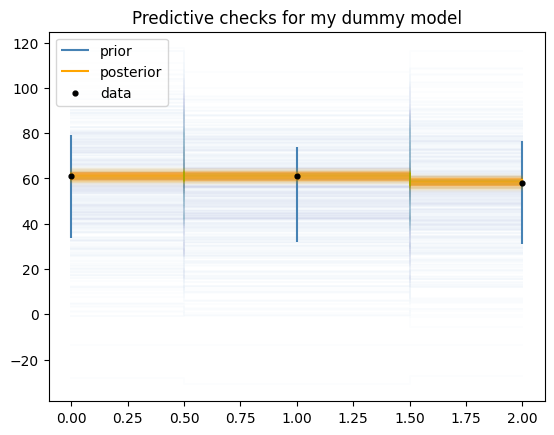

In [5]:
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label='posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Predictive checks for my dummy model')

plt.show()

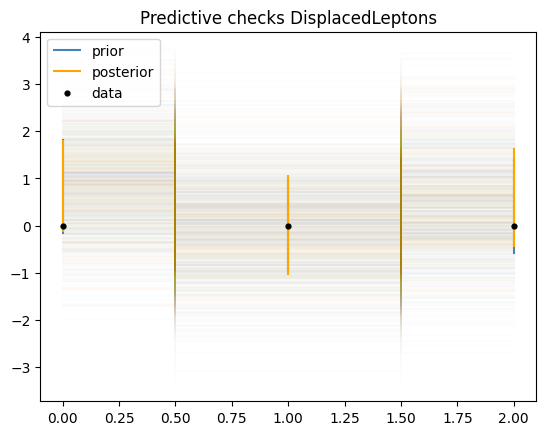

In [9]:
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label='posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Predictive checks DisplacedLeptons')

plt.show()

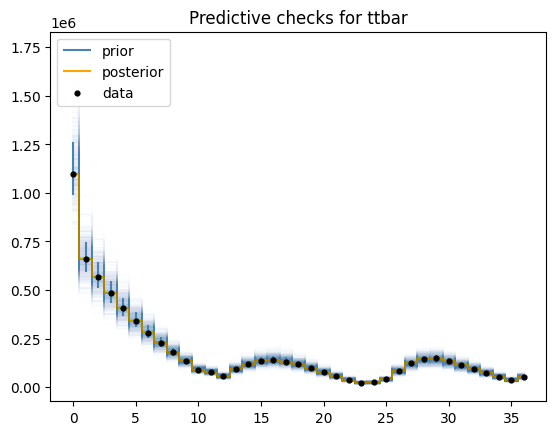

In [6]:
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label='posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Predictive checks for ttbar')

plt.show()

# Random

In [170]:
    target, indices = [], []
    unconstr_mu, unconstr_sigma, norm_mu, norm_sigma, poiss_pars = [], [], [], [], []
    unconstr_idx, norm_idx, poiss_idx = [], [], []

    unconstr_input = [1, 0.1]

    norm_poiss_dict = {}

    for k, v in model.config.par_map.items():
        if isinstance(v['paramset'], pyhf.parameters.unconstrained):
            unconstr_idx = np.concatenate([
                np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.unconstrained)
                ])
            break

    for k, v in model.config.par_map.items():
        if isinstance(v['paramset'], pyhf.parameters.paramsets.constrained_by_normal):
            norm_idx = np.concatenate([
                np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal)
                ])
            break

    for k, v in model.config.par_map.items():
        if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson):
            poiss_idx = np.concatenate([
                np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_poisson)
                ])
            break

    for i in [unconstr_idx, norm_idx, poiss_idx]:
        i = np.array(i)
        if i.size != 0:
            indices.append(i)
    target = np.concatenate(indices)

    target

array([ 4,  0,  1,  2,  3, 14, 15, 16,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [171]:
class ExpDataClass(pt.Op):
    """
    Input: 
        - name
        - func (model.expected_actualdata())
    Output: 
        - Object that can take tensor_variables as input and returns the value of func
    """
    itypes = [pt.dvector]  
    otypes = [pt.dvector]  

    def __init__(self, name, func):
        ## Add inputs as class attributes
        self.func = func
        self.name = name

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (theta,) = inputs  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = self.func(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

In [172]:
prepared_model.keys()
prior_dict = prepared_model['priors']
for key in prior_dict.keys():
    sub_dict = prior_dict[key]
    print(sub_dict)
    # print(sub_dict['input'])

print('....')
print(prior_dict)


{'type': 'unconstrained', 'type2': 'normal', 'input': [[1], [0.1]]}
{'type': 'normal', 'input': [[0.0], [Array(1., dtype=float64)]]}
{'type': 'normal', 'input': [[0.0], [Array(1., dtype=float64)]]}
{'type': 'normal', 'input': [[0.0], [Array(1., dtype=float64)]]}
{'type': 'normal', 'input': [[1.0], [Array(0.017, dtype=float64)]]}
{'type': 'normal', 'input': [[1.0, 1.0, 1.0], [Array(0.04363636, dtype=float64), Array(0.04363636, dtype=float64), Array(0.04363636, dtype=float64)]]}
{'type': 'poisson', 'input': [[235281.56316670778, 105593.26410293579, 203732.91681304327], [235281.56316670778, 105593.26410293579, 203732.91681304327]]}
{'type': 'poisson', 'input': [[235281.56316670778, 105593.26410293579, 306004.1530842913], [235281.56316670778, 105593.26410293579, 306004.1530842913]]}
{'type': 'poisson', 'input': [[187486.3575706435, 52086.00884199751, 235281.56316670778], [187486.3575706435, 52086.00884199751, 235281.56316670778]]}
....
{'uncon1': {'type': 'unconstrained', 'type2': 'normal'

In [7]:
unconstr_pars, norm_pars, poiss_pars = [], [], []
norm_mu, norm_sigma = [], []
poiss_alpha, poiss_beta = [], []
with pm.Model():
    for key in prior_dict.keys():
        sub_dict = prior_dict[key]

        if sub_dict['type'] == 'unconstrained':
            # print('unconstrained')
            # print(sub_dict['input'][0])
            # print(sub_dict['input'][1])
            unconstr_pars.extend(pm.Normal('Unconstrained', mu=sub_dict['input'][0], sigma=sub_dict['input'][1]))


        if sub_dict['type'] == 'normal':
            # print('normal')
            # print(sub_dict['input'][0])
            # print(sub_dict['input'][1])
            norm_mu.append(sub_dict['input'][0])
            norm_sigma.append(sub_dict['input'][1])
        

        if sub_dict['type'] == 'poisson':
            # print('poisson')
            # print(sub_dict['input'][0])
            # print(sub_dict['input'][1])
            poiss_alpha.append(sub_dict['input'][0])
            poiss_beta.append(sub_dict['input'][1])


    norm_pars.extend(pm.Normal('Normals', mu=list(np.concatenate(norm_mu)), sigma=list(np.concatenate(norm_sigma))))
    poiss_pars.extend(pm.Gamma('Gammas', alpha=list(np.concatenate(poiss_alpha)), beta=list(np.concatenate(poiss_beta))))

    pars = np.concatenate([unconstr_pars, norm_pars, poiss_pars])
    # pars = np.concatenate([unconstr_pars, norm_pars])
    # print(pars)
    final = pt.as_tensor_variable(pars[target.argsort()].tolist())
    
    mainOp = external4.ExpDataClass('mainOp', jax.jit(model.expected_actualdata))

    main = pm.Normal('main', mu=mainOp(final), observed=obs)
    post_data = pm.sample(500)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(500)

    

# print(pars)
# print('...')
# print(unconstr_pars)
# print(norm_pars)
# print(poiss_pars)
# print(list(np.concatenate(norm_mu)))
# print(list(np.concatenate(norm_sigma)))

NameError: name 'target' is not defined

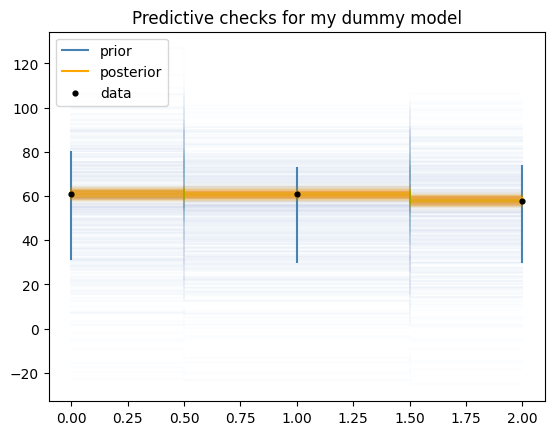

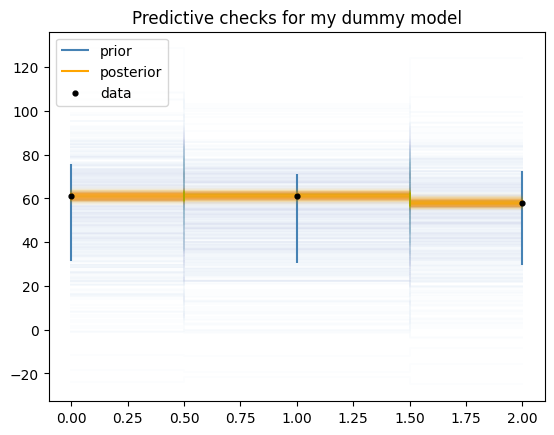

In [202]:
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label='posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Predictive checks for my dummy model')

plt.show()

In [8]:
def posterior_sampling(model, prior_dict):

        with pm.Model():
            unconstr_pars, norm_pars, poiss_pars = [], [], []

            mu, sigma = [], []
            for key in prior_dict.keys():
                sub_dict = prior_dict[key]

                if sub_dict['type'] == 'normal':
                    mu.append(list(sub_dict['input'][0]))
                    sigma.append(sub_dict['input'][1])

            print(list(mu))
            print(sigma)
                    
            # unconstr_pars.extend(pm.Normal('Normals', mu=list(mu), sigma=list(sigma)))
                # print(unconstr_pars)

        #     if any(a == 'u' for a in b):
        #         unconstr_pars.extend(pm.Normal(f'{model.config.poi_name}', mu=prepared_priors[1][0], sigma=prepared_priors[2][0]))
        #     if any(a == 'n' for a in b):
        #         norm_pars.extend(pm.Normal('Normals', mu=prepared_priors[3], sigma=prepared_priors[4]))
        #     if any(a == 'p' for a in b):
        #         poiss_pars.extend(pm.Gamma('Gamma', alpha=prepared_priors[5], beta=prepared_priors[5]))
            
        #     pars = np.concatenate([unconstr_pars, norm_pars, poiss_pars])

        #     final = pt.as_tensor_variable(pars[prepared_priors[0].argsort()].tolist())

        #     mainOp = ExpDataClass('mainOp', jax.jit(model.expected_actualdata))

        #     main = pm.Normal('main', mu=mainOp(final), observed=obs)
        #     post_data = pm.sample(n_samples)
        #     post_pred = pm.sample_posterior_predictive(post_data)

        # return post_data, post_pred
        return


In [10]:
posterior_sampling(model, prepared_priors)

AttributeError: 'list' object has no attribute 'keys'

In [212]:
def prepare_model(model, observations, prior_dict, precision):
    model_dict = {}
    model_dict['model'] = model
    model_dict['obs'] = observations
    model_dict['priors'] = prior_dict
    model_dict['precision'] = precision

    return model_dict

prepare_model(model, obs, prepared_priors, 0.2)

{'model': <pyhf.pdf.Model at 0x168ff5040>,
 'obs': [9.99999993922529e-09, 9.99999993922529e-09, 9.99999993922529e-09],
 'priors': [array([ 72,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
          12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
          25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
          38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
          51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
          64,  65,  66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131]),
  [[1]],
  [[0.01]],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
 

In [76]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Opening the PyMC model space
with pm.Model() as basic_model:

    ## Stitching
    unconstr_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.unconstrained)
    ])
    norm_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal)
    ])
    
    target = np.array(np.concatenate([unconstr_idx, norm_idx]))
    ### Target vecor for ttbar
    # target = np.array([72, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
    #     41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 
    #     85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97])
    
    

    ## Parameters
    unconstr_pars = []
    unconstr_pars.extend(pm.Normal(f'{model.config.poi_name}', mu=[0], sigma=[1]))

    norm_pars = []
    mu = []
    sigma = []
    for k,v in model.config.par_map.items():
        if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal):
            mu.append(model.config.auxdata[model.config.auxdata_order.index(k)])
            sigma.append(1)
            # if 
    norm_pars.extend(pm.Normal('Normals', mu=mu, sigma=sigma))

    pars = np.concatenate([unconstr_pars, norm_pars])
    final = pt.as_tensor_variable(pars[target.argsort()].tolist())
    
    ## Model for the model.expected_actualdata()
        # Attention: pm.Poisson breaks down, as \lambda < 0 occasionally if mu=0.0
    main = pm.Normal("main", mu=mainOp(final), observed=obs)

    ## Sampling
    post_data = pm.sample(500)
    prior_data = pm.sample_prior_predictive(500)
    post_pred = pm.sample_posterior_predictive(post_data)

TypeError: Op() takes no arguments

# sampling

/var/folders/p9/sw_pjm3j027cxfs57s_91bfw0000gn/T/ipykernel_4371/4135405629.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.array(norm_mu).size != 0:


Sampling: [Normals, Unconstrained, main]


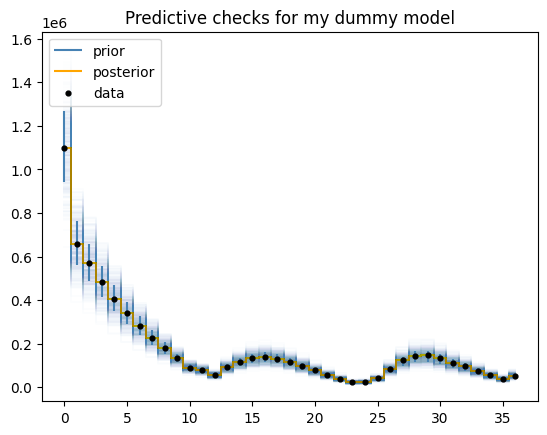

In [20]:
post_data, post_pred, prior_pred = sampling(prepared_model)
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label='posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Predictive checks for my dummy model')

plt.show()